# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [240]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
import pandas as pd

import sklearn.cluster as sk

In [241]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

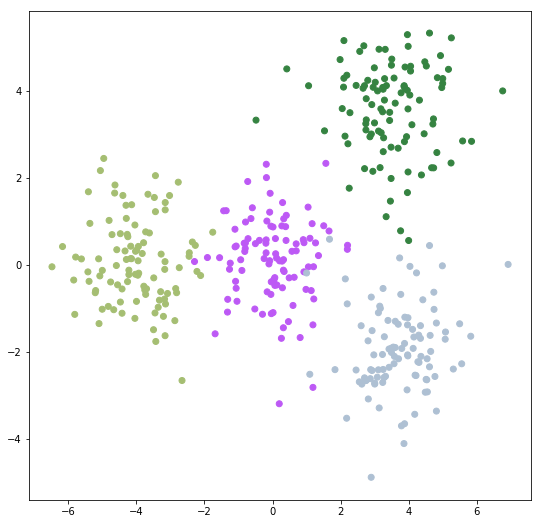

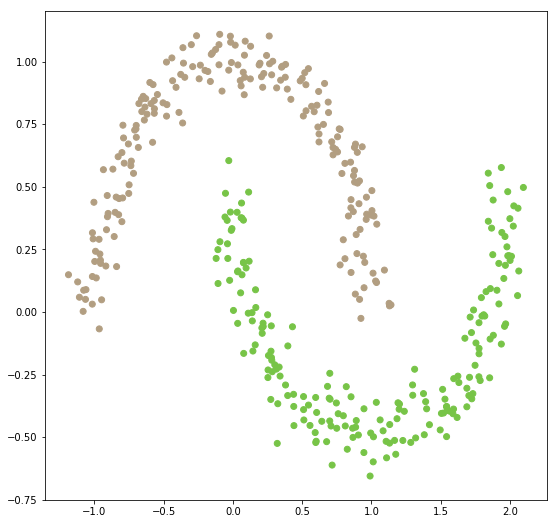

In [242]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (2 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [228]:
from numpy.random import choice 
from sklearn.metrics import pairwise_distances_argmin

class KMeans:
    def __init__(self, n_clusters, init="sample", max_iter=300):
        self.clustersCount = n_clusters
        self.initType = init
        self.maxIterations = max_iter
    
    def _calcNearestCluster(self,x):
        minIndex = 0
        minDist = np.inf
        for i, centroid in enumerate(self.centroids):
            dist = np.linalg.norm(x - centroid)
            if(dist<minDist):
                minDist = dist
                minIndex = i
        return minIndex, minDist
    
    def fit(self, X, y=None):
        
        self.clusterNumbers = np.zeros(X.shape[0], dtype=int)
        if(self.initType=="random"):
            xMax = X.max(axis = 0)
            xMin = X.min(axis = 0)
            self.centroids = np.random.rand(self.clustersCount,X.shape[1])
            self.centroids = self.centroids * (xMax - xMin) + xMin 
        elif(self.initType=="sample"):
            rng = np.random.RandomState()
            i = rng.permutation(X.shape[0])[:self.clustersCount]
            self.centroids = X[i]
        elif(self.initType=="k-means++"):
            self.centroids = []
            self.centroids.append(X[random.randrange(X.shape[0])])
            while(len(self.centroids)!=self.clustersCount):
                
                nearestClustersDistances = [self._calcNearestCluster(x)[1] for x in X]
                dSum = sum(d*d for d in nearestClustersDistances)
                probs = [d*d/dSum for d in nearestClustersDistances]
                
                chosenCluster = X[choice(X.shape[0], p=probs)]
                self.centroids.append(chosenCluster)
            
        itCount = 0
        while(itCount < self.maxIterations):
            self.clusterNumbers = pairwise_distances_argmin(X, self.centroids)
            #for (i, x) in enumerate(X):
            #    self.clusterNumbers[i] = _calcNearestCluster(x)
            
            for cluster in range(0, self.clustersCount):
                inds = np.where(self.clusterNumbers==cluster)
                self.centroids[cluster] = X[inds].mean(axis=0)
            itCount+=1
            
    def predict(self, X):
        return self.clusterNumbers

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

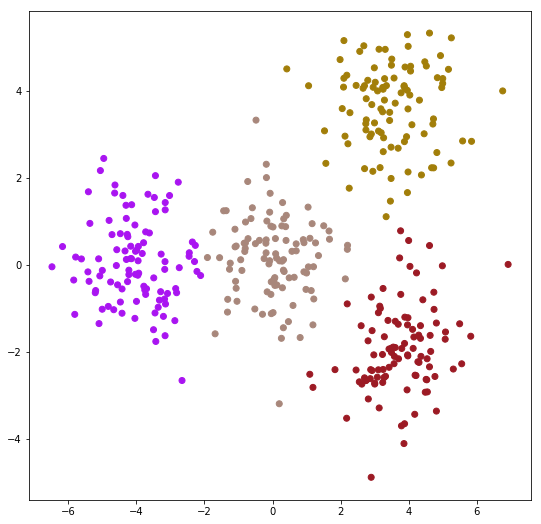

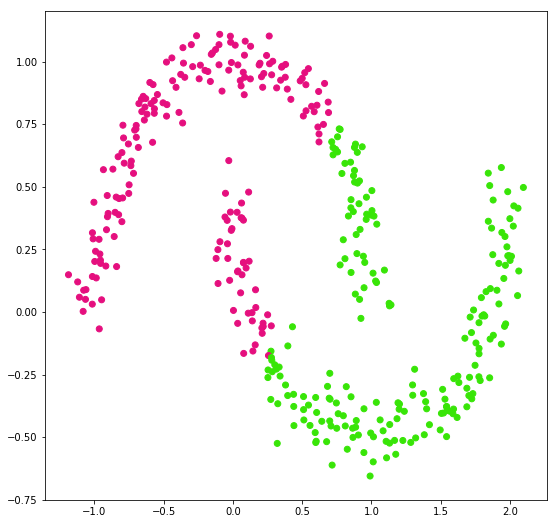

In [292]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)


kmeans = KMeans(n_clusters=2, init="k-means++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)


### Задание 2 (4 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [237]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.minSamples = min_samples
        self.leafSize = leaf_size    
        self.metric = metric
    

    def fit_predict(self, X, y=None):
        
        #0 - точка не обработана
        #1 - точка помечена как выброс
        #2,3,... - точка отнесена к определённому кластеру
        labels = np.zeros(X.shape[0], dtype=int)
        tree = KDTree(X, leaf_size=self.leafSize, metric=self.metric)
        curClass = 1

        for (i,x) in enumerate(X):
            if(labels[i]!=0):
                continue
                
            neighbourIds = tree.query_radius(x.reshape(1, -1), r=self.eps)
            if(len(neighbourIds[0])>=self.minSamples):
                labels[i] = curClass + 1
            else:
                labels[i] = 1
                continue
                
            curClass+=1

            neighboursQueue = []
            neighboursQueue.extend(neighbourIds[0])
            while(len(neighboursQueue)>0):
                curNeighbourId = neighboursQueue.pop()

                if(labels[curNeighbourId]==1):
                    labels[curNeighbourId] = curClass
                    continue
                    
                if(curNeighbourId==i or labels[curNeighbourId]!=0):
                    continue
                    
                labels[curNeighbourId] = curClass
                    
                neighbourIds = tree.query_radius(X[curNeighbourId].reshape(1, -1), r=self.eps)
                if(len(neighbourIds[0])>=self.minSamples):
                    neighboursQueue.extend(neighbourIds[0])
                
        if(1 not in labels):
            labels = labels-1
        return labels-1

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

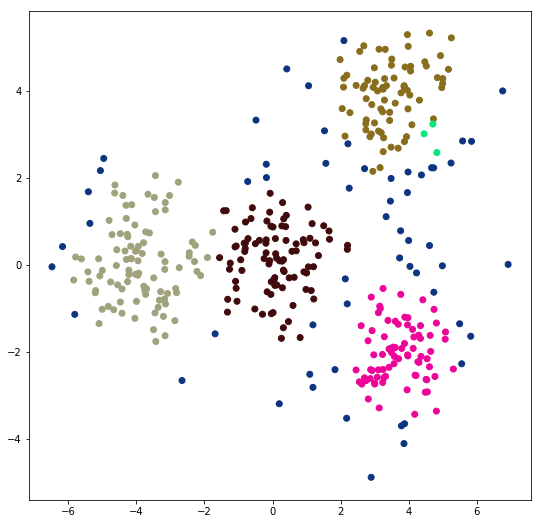

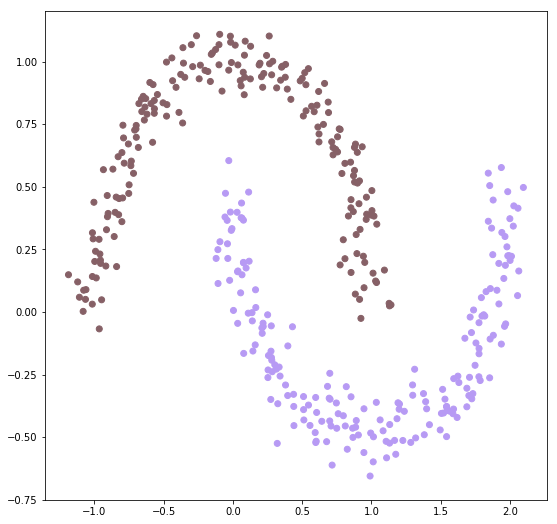

In [288]:
dbscan = DBScan(eps=0.616, min_samples=7)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)



dbscan = DBScan(eps=0.2, min_samples=5)
labels = dbscan.fit_predict(X_2)

visualize_clasters(X_2, labels)

### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [249]:
class AgglomerativeClusteringMy:
    def __init__(self, n_clusters=16, linkage="average"):
        self.clustersCount = n_clusters
        self.linkage = linkage

    def __calcSimilarityAverageLinkage(self, x,y):
        distSum = 0
        for p1 in x:
            for p2 in y:
                distSum += np.linalg.norm(p1[1]-p2[1])
        return distSum/(len(x)*len(y))
                     
    def __calcSimilaritySingleLinkage(self, x,y):
        distSum = 0
        elements = []
        for p1 in x:
            for p2 in y:
                elements.append(np.linalg.norm(p1[1]-p2[1]))
        return min(elements)
        
        
    def __calcSimilarityCompleteLinkage(self, x,y):
        distSum = 0
        elements = []
        for p1 in x:
            for p2 in y:
                elements.append(np.linalg.norm(p1[1]-p2[1]))
        return max(elements)
        
    def __calcSimilarity(self, x, y):
        if(self.linkage=="complete"):
            return self.__calcSimilarityCompleteLinkage(x,y)
        elif(self.linkage=="single"):
            return self.__calcSimilaritySingleLinkage(x,y)
        else:
            return self.__calcSimilarityAverageLinkage(x,y)
        
    def __getMinClusters(self, clusters):
        minDist = 1000000
        selCl1 = -1
        selCl2 = -1
        for i, cl1 in enumerate(clusters):
            for j, cl2 in enumerate(clusters):
                if(i!=j):
                    dist = self.__calcSimilarity(cl1, cl2)
                    if(dist<minDist):
                        minDist = dist
                        selCl1 = i
                        selCl2 = j
        return selCl1, selCl2
        
    
    
    def fit_predict(self, X, y=None):
        
        X_df = pd.DataFrame(X)
        #i - номер в исходном датасете, x - сам элемент
        clusters = [[(i,x)] for i,x in enumerate(X)]

        while(len(clusters)>self.clustersCount):
            i,j = self.__getMinClusters(clusters)
            clusters[i].extend(clusters[j])
            del clusters[j]
            
        t_labels = np.zeros(len(X),dtype=int)
        for cluster_id, cluster in enumerate(clusters):
            for x in cluster:
                t_labels[x[0]] = cluster_id

        return t_labels

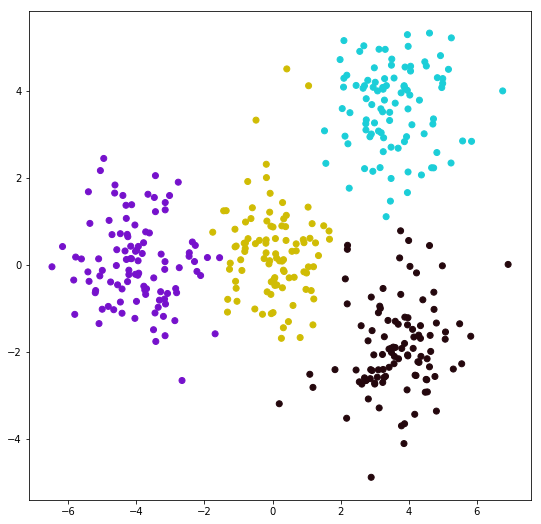

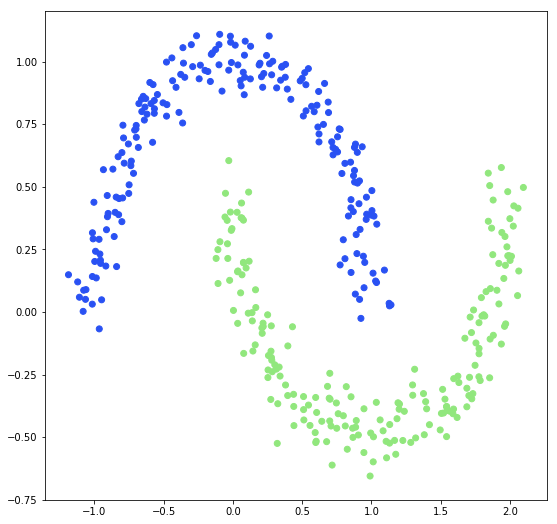

In [250]:
agg_clustering =AgglomerativeClusteringMy(n_clusters=4, linkage="average")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

    
agg_clustering =AgglomerativeClusteringMy(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

    